<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Project Title: Air Quality and Health Impact Analysis</span>
</h1>


## Objective:
The goal of this project is to analyze how air pollution indicators (PM2.5, PM10, NO2, SO2, O3, etc.)
influence public health outcomes such as respiratory and cardiovascular cases and hospital admissions.
We aim to:
1. Identify key air pollutants that most strongly impact health.
2. Quantify the relationship between air quality index (AQI) and health impact score.
3. Build predictive models to estimate health impact scores from air pollution data.

## Problem Type:
Supervised Machine Learning – Regression Problem
(Target: HealthImpactScore)

## Expected Outcome:
- Insights on pollution-health correlation.
- Predictive model to estimate health risks based on AQI and pollutants.
"""


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Import libraries and load data</span>
</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint

import lazypredict
from lazypredict.Supervised import LazyClassifier, LazyRegressor

import warnings
warnings.filterwarnings('ignore')

# np.random.seed(1)
plt.style.use('ggplot')

Dataset Source: Kaggle (Air Quality and Health Impact Dataset)
The dataset contains measurements of air pollutants, weather data, and related health impact scores.

- Rows: 5811
- Columns: 15



In [2]:
df = pd.read_csv('data/raw/air_quality_health_impact_data.csv')


# 🗂️ Dataset Description

| Column | Description |
|--------|--------------|
| RecordID | Unique record identifier |
| AQI | Air Quality Index |
| PM10 | Particulate Matter <10μm |
| PM2_5 | Particulate Matter <2.5μm |
| NO2 | Nitrogen Dioxide concentration |
| SO2 | Sulfur Dioxide concentration |
| O3 | Ozone concentration |
| Temperature | Ambient temperature |
| Humidity | Relative humidity |
| WindSpeed | Average wind speed |
| RespiratoryCases | Reported respiratory disease cases |
| CardiovascularCases | Reported cardiovascular cases |
| HospitalAdmissions | Total hospital admissions |
| HealthImpactScore | Combined index reflecting health impact |
| HealthImpactClass | Categorical class of impact (Low/Medium/High) |


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Data Exploration</span>
</h1>

In [3]:
df.shape

(5811, 15)

In [4]:
df.head()

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.27,295.85,13.04,6.64,66.16,54.62,5.15,84.42,6.14,7,5,1,97.24,0.00
1,2,475.36,246.25,9.98,16.32,90.50,169.62,1.54,46.85,4.52,10,2,0,100.00,0.00
2,3,366.00,84.44,23.11,96.32,17.88,9.01,1.17,17.81,11.16,13,3,0,100.00,0.00
3,4,299.33,21.02,14.27,81.23,48.32,93.16,21.93,99.47,15.30,8,8,1,100.00,0.00
4,5,78.01,16.99,152.11,121.24,90.87,241.80,9.22,24.91,14.53,9,0,1,95.18,0.00


In [5]:
categorical_features = df.select_dtypes(include='object').columns.tolist()

numerical_features = df.select_dtypes(exclude='object').columns.tolist()

for feature in ['HealthImpactScore', 'RecordID','HealthImpactClass']:
    if feature in numerical_features:
        numerical_features.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

df_numerical

,Numerical Variables
0,AQI
1,PM10
2,PM2_5
3,NO2
4,SO2
5,O3
6,Temperature
7,Humidity
8,WindSpeed
9,RespiratoryCases


In [6]:
df_categorical

,Categorical Variables


In [7]:
df.describe()

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
count,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00,5811.00
mean,2906.00,248.44,148.65,100.22,102.29,49.46,149.31,14.98,54.78,9.99,9.97,4.99,2.00,93.79,0.28
std,1677.64,144.78,85.70,58.10,57.71,28.53,86.53,14.48,26.02,5.78,3.13,2.22,1.40,13.32,0.71
min,1.00,0.01,0.02,0.03,0.01,0.01,0.00,-9.99,10.00,0.00,1.00,0.00,0.00,22.45,0.00
25%,1453.50,122.95,75.37,49.44,53.54,24.89,74.00,2.48,32.00,4.95,8.00,3.00,1.00,98.20,0.00
50%,2906.00,249.13,147.63,100.51,102.99,49.53,149.56,14.94,54.54,10.05,10.00,5.00,2.00,100.00,0.00
75%,4358.50,373.63,222.44,151.34,151.66,73.35,223.38,27.47,77.64,14.97,12.00,6.00,3.00,100.00,0.00
max,5811.00,499.86,299.90,199.98,199.98,99.97,299.94,39.96,100.00,20.00,23.00,14.00,12.00,100.00,4.00


In [8]:
df_null_sum = df.isnull().sum().to_frame(name='Missing Values')
df_null_sum

,Missing Values
RecordID,0
AQI,0
PM10,0
PM2_5,0
NO2,0
SO2,0
O3,0
Temperature,0
Humidity,0
WindSpeed,0


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
def count_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)


In [11]:
outliers = []
for index, col in enumerate(numerical_features):
    column_data = numerical_features[index]
    outliers.append({
        'Feature' : col,
        'Num of outliers' : count_outliers(col)
    })
pd.DataFrame(outliers)

,Feature,Num of outliers
0,AQI,0
1,PM10,0
2,PM2_5,0
3,NO2,0
4,SO2,0
5,O3,0
6,Temperature,0
7,Humidity,0
8,WindSpeed,0
9,RespiratoryCases,42


In [12]:
custom_palette = ['#C0C78C','#B99470','#FEFAE0',  '#A6B37D']
# Set the custom palette in seaborn
sns.set_palette(custom_palette)

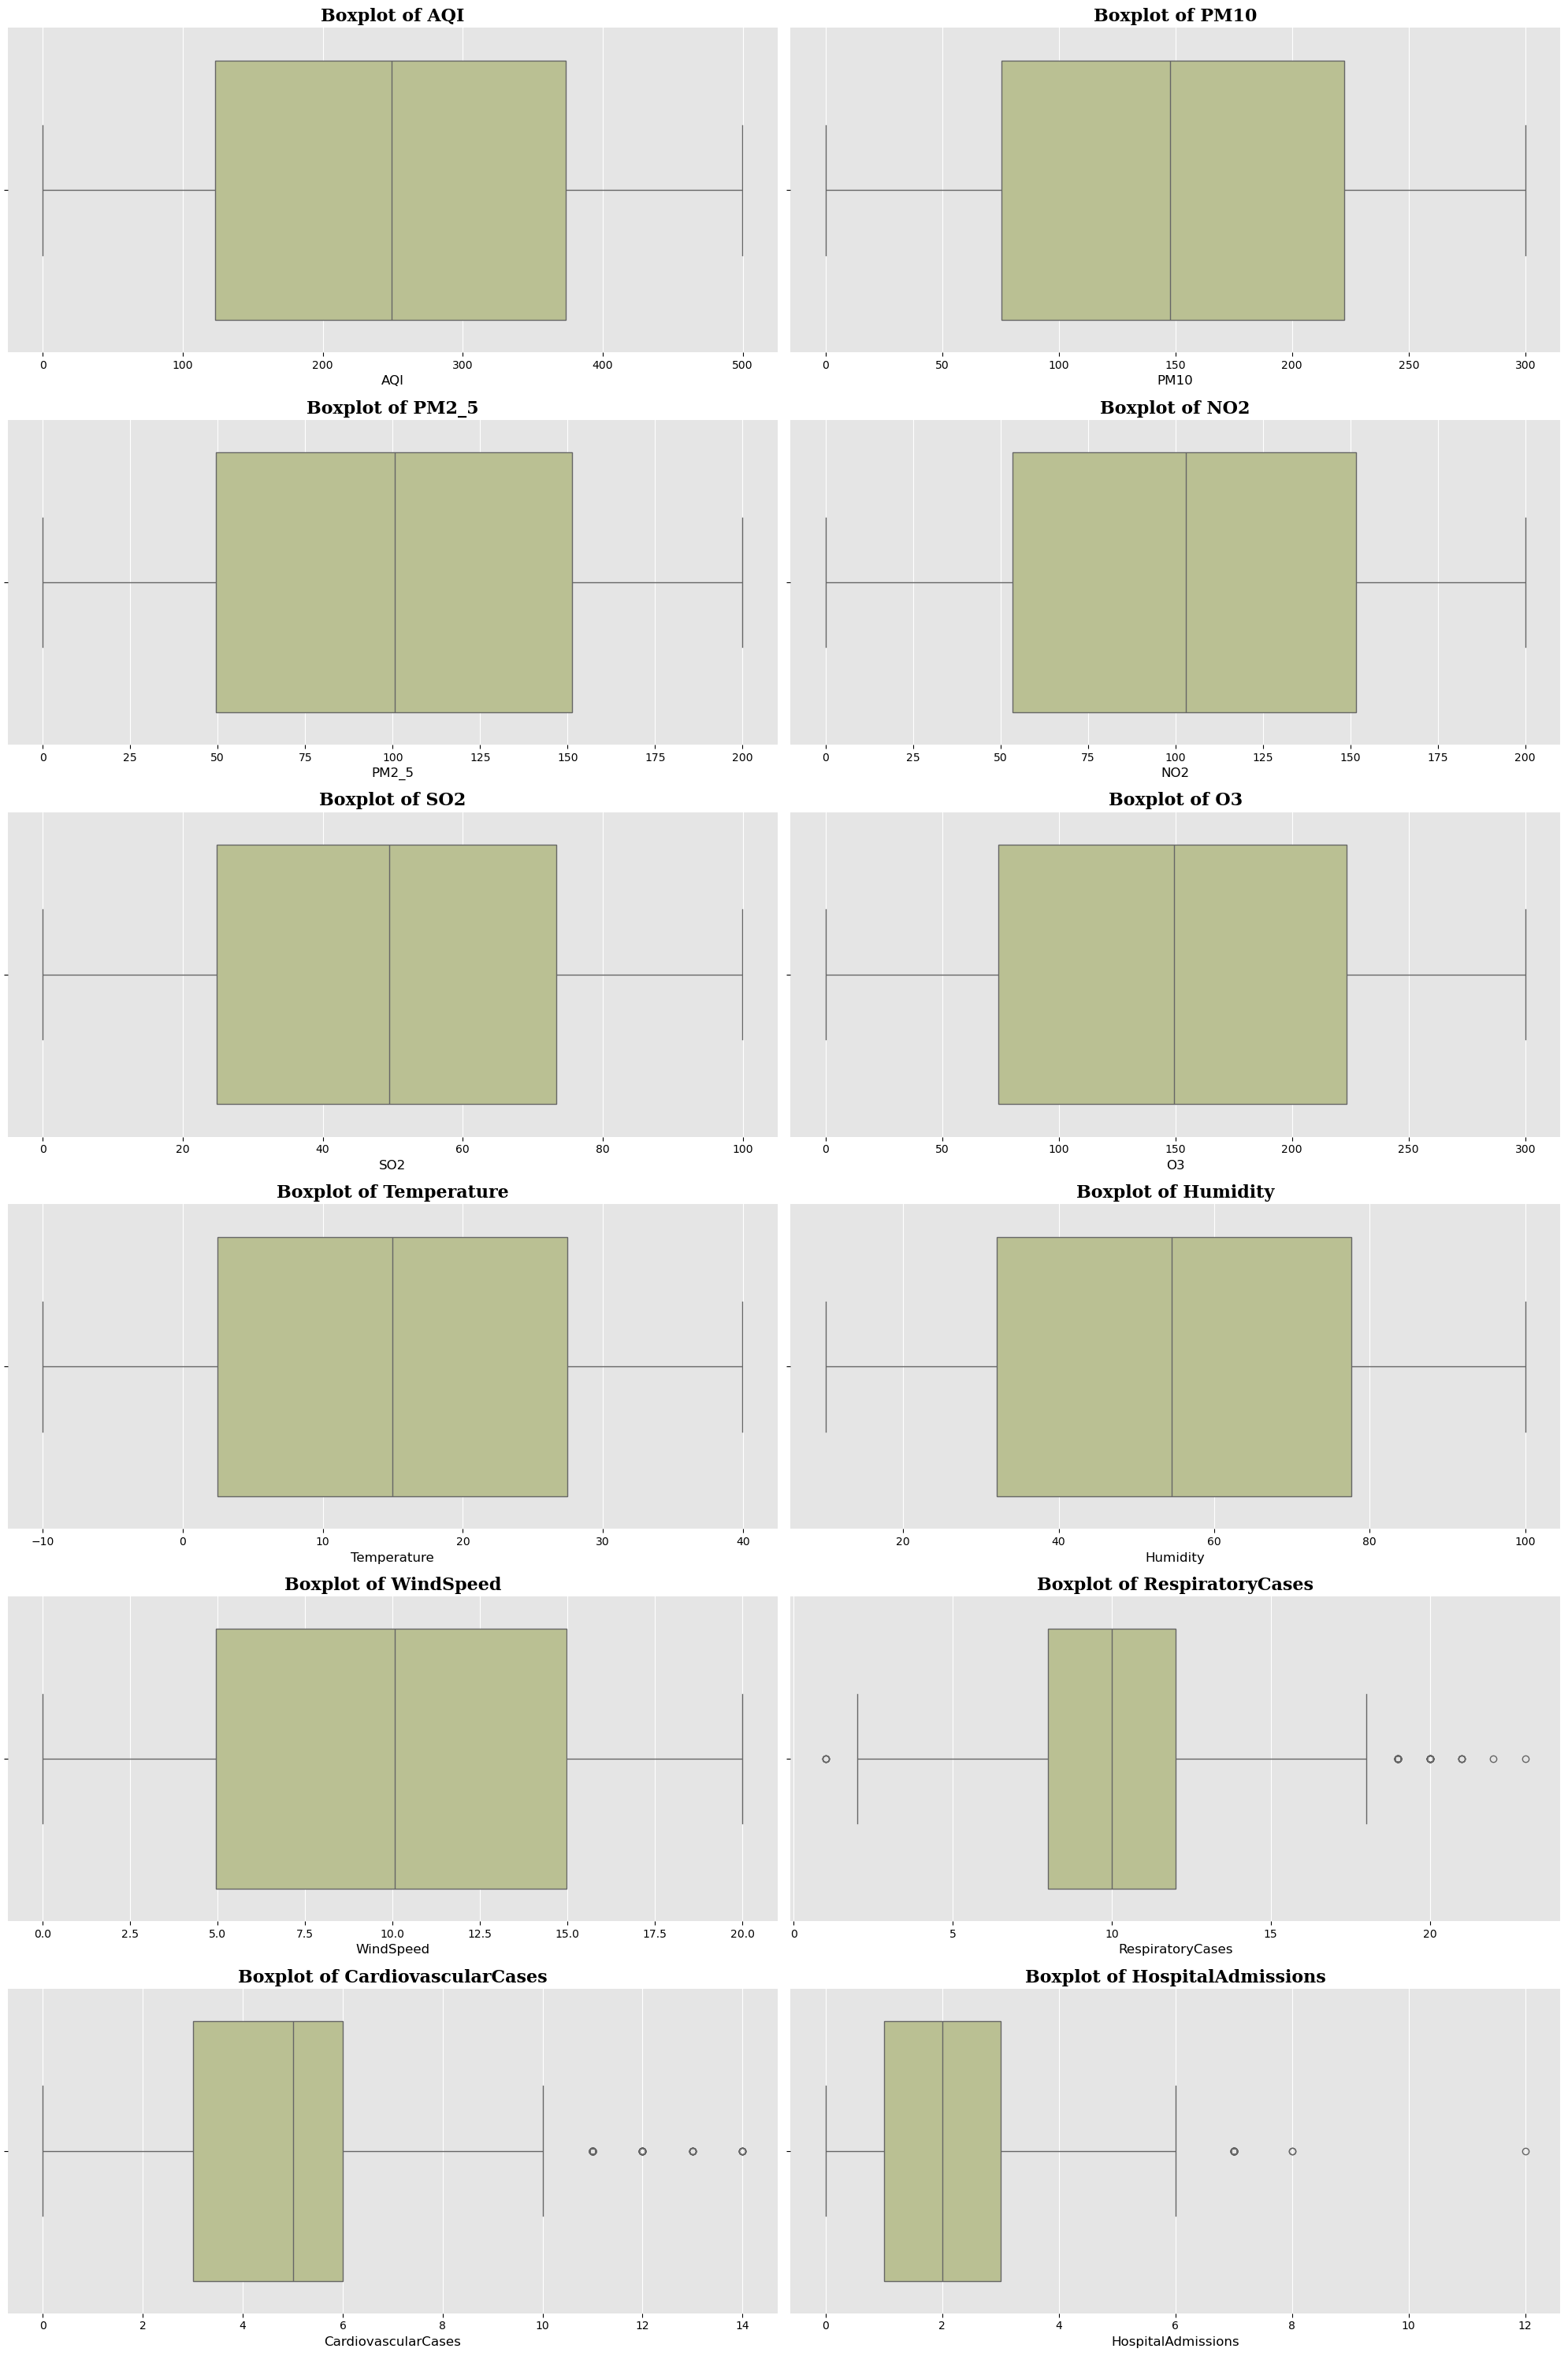

In [13]:
num_cols = len(numerical_features)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(ax=axes[i], x=col, data=df, palette=custom_palette)
    axes[i].set_title(f'Boxplot of {col}', fontdict={'font': 'Serif', 'color': 'k', 'size': 16, 'weight': 'bold'})
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].tick_params(axis='x', colors='k')  # Set x-axis tick color
    axes[i].tick_params(axis='y', colors='k')  # Set y-axis tick color
    axes[i].xaxis.label.set_color('k')  # Set x-axis label color
    axes[i].yaxis.label.set_color('k')  # Set y-axis label color

# Turn off unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

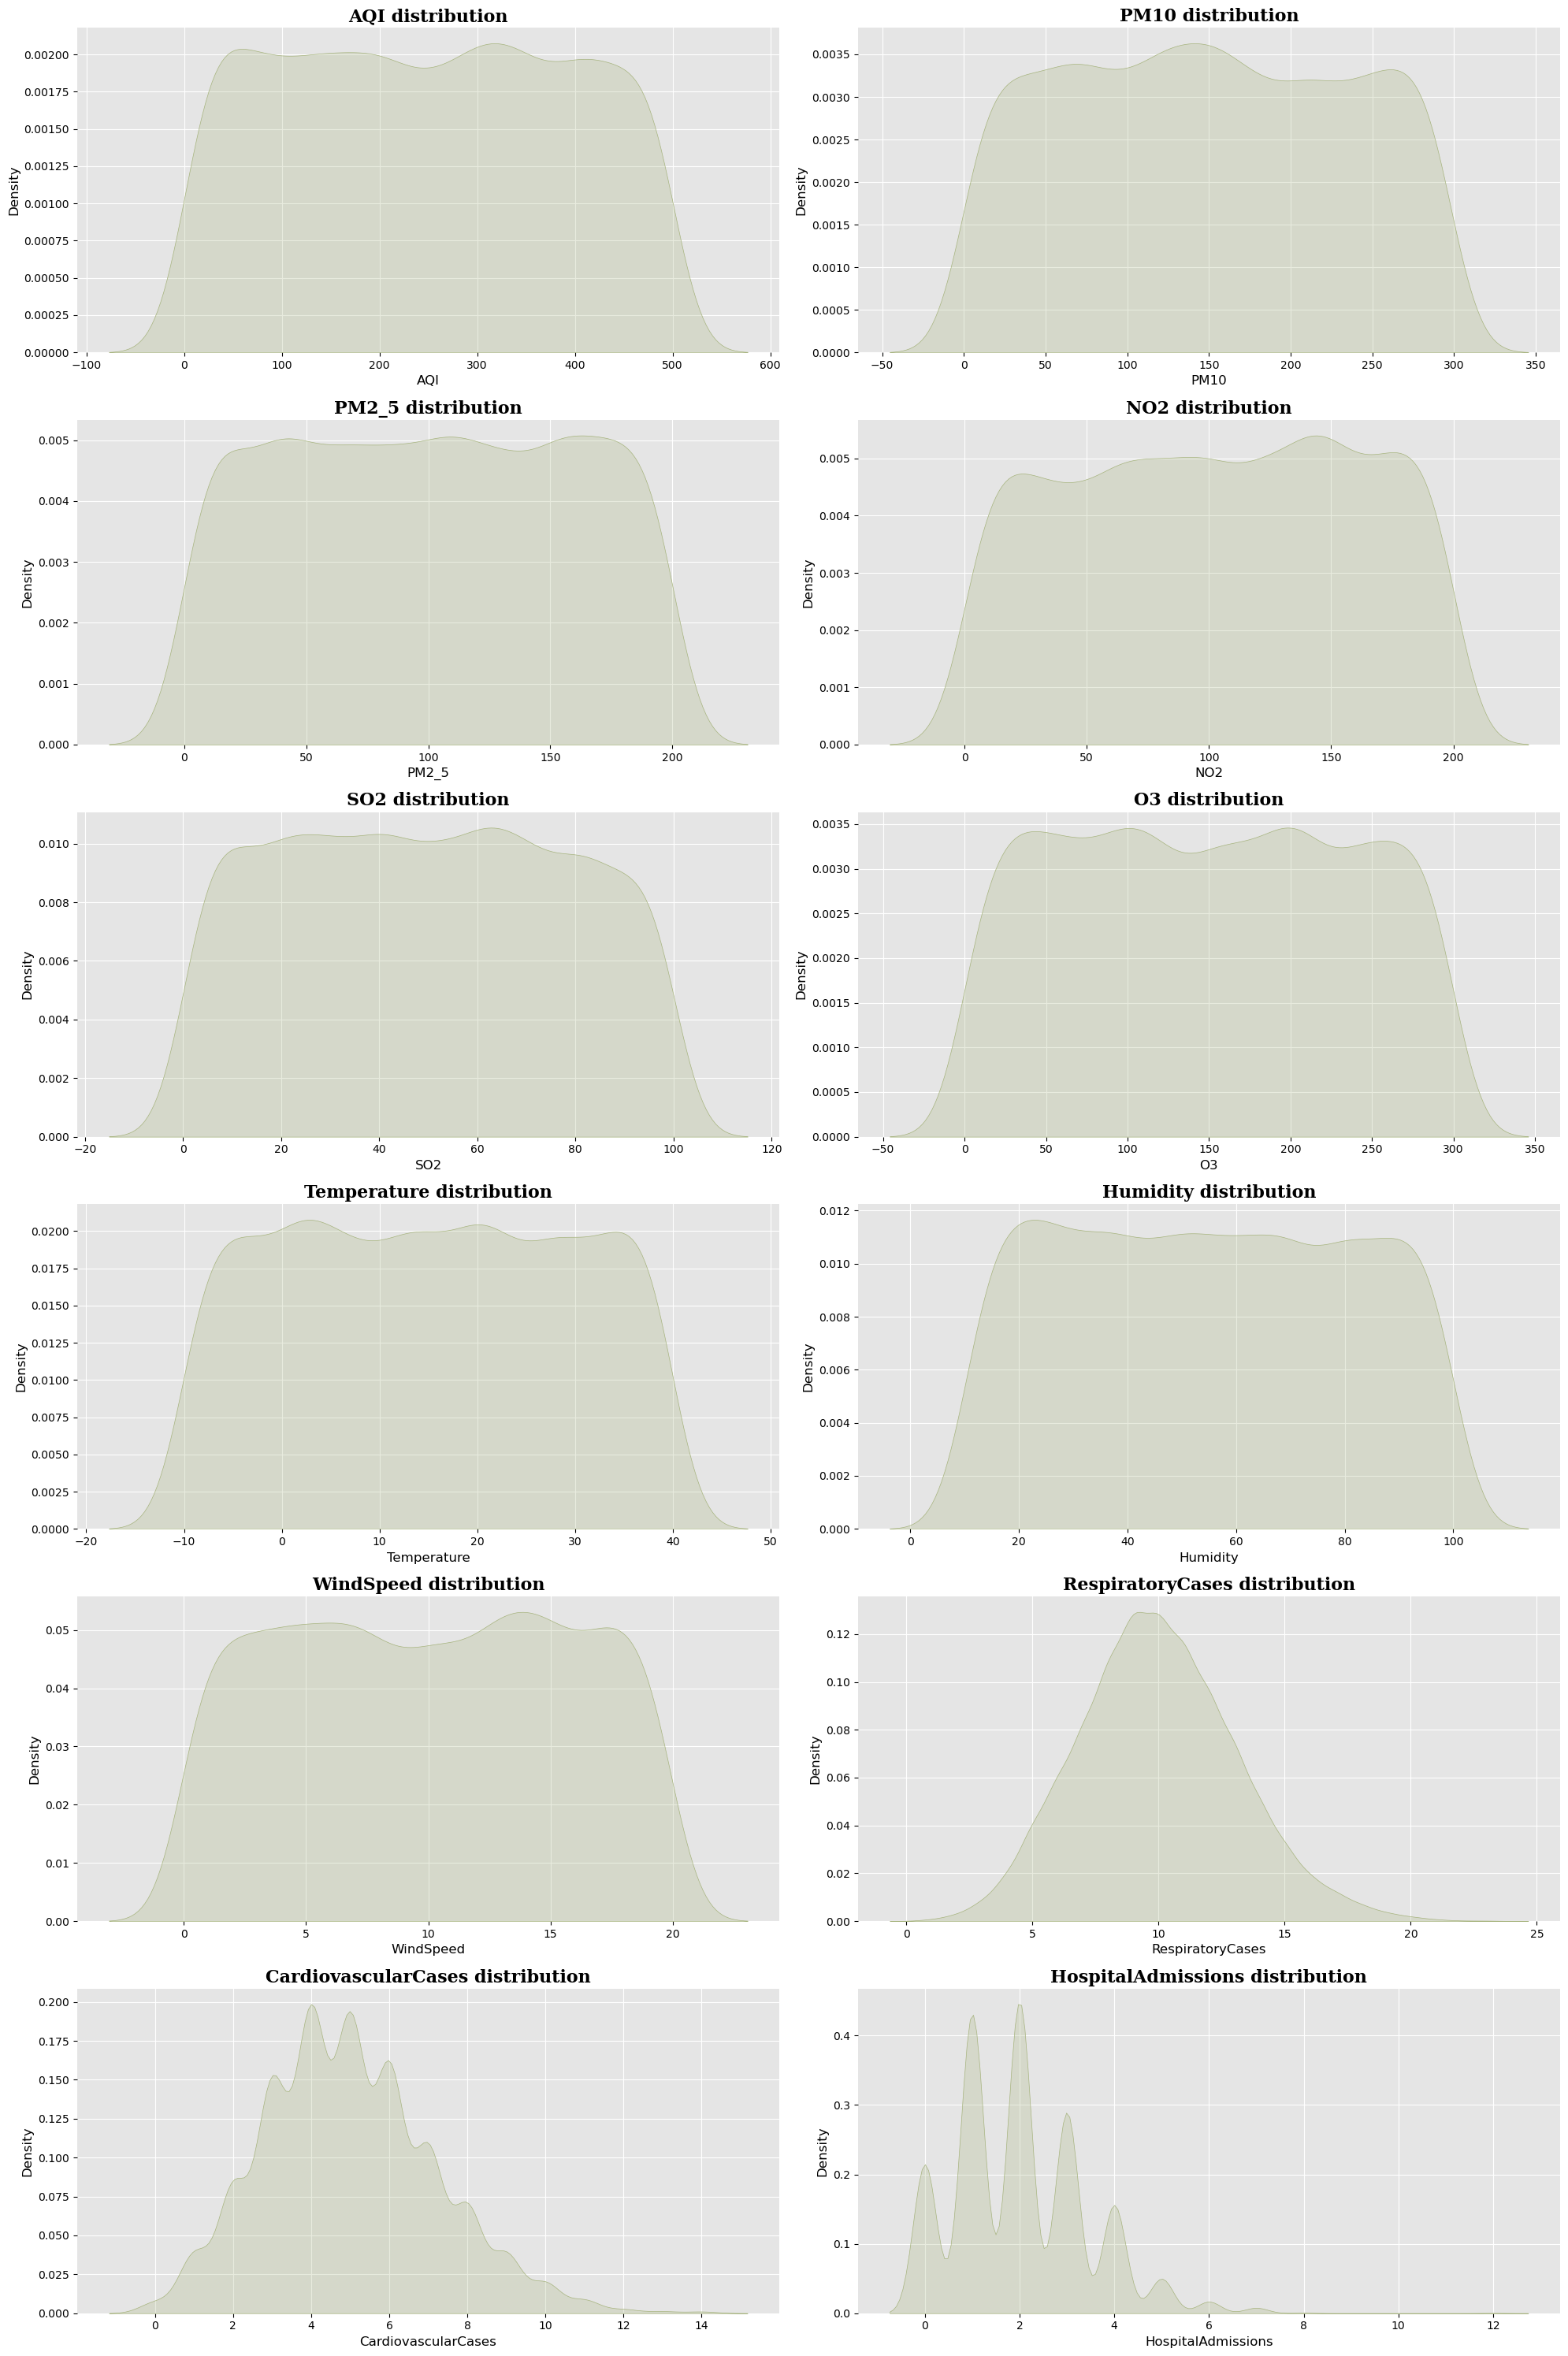

In [14]:
num_cols = len(numerical_features)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.kdeplot(ax=axes[i], x=col, data=df, fill=True, color='#A6B37D')
    axes[i].set_title(f'{col} distribution', fontdict={'font': 'Serif', 'color': 'k', 'size': 16, 'weight': 'bold'})
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].tick_params(axis='x', colors='k')  # Set x-axis tick color
    axes[i].tick_params(axis='y', colors='k')  # Set y-axis tick color
    axes[i].xaxis.label.set_color('k')  # Set x-axis label color
    axes[i].yaxis.label.set_color('k')  # Set y-axis label color

# Turn off unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

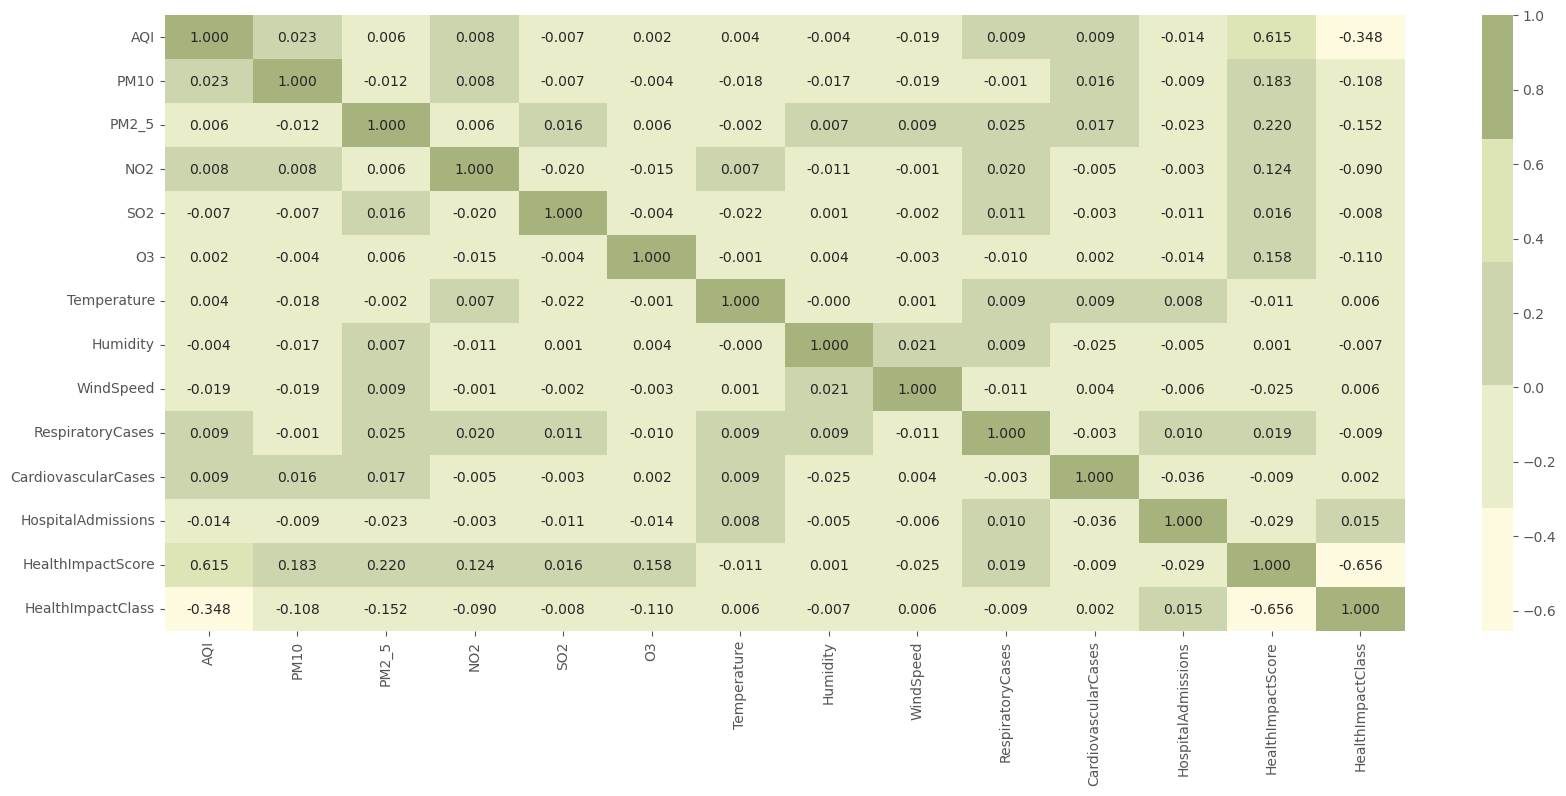

In [15]:
plt.figure(figsize=(20, 8))
num_deatures = df.select_dtypes(exclude='object').columns.tolist()
num_deatures.remove('RecordID')
corr_matrix = df[num_deatures].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=['#FEFAE0', '#E9EDC9', '#CCD5AE', '#DDE5B6', '#A6B37D'],
    fmt='.3f'
)

plt.show()

# **Dataset Summary**

- The dataset contains **5811 rows** and **15 columns**.  
- **No missing values** or **duplicate records** were found.  
- **Outliers** were detected in three features:  
  - `RespiratoryCases`  
  - `CardiovascularCases`  
  - `HospitalAdmissions`  
  These will be addressed during data preprocessing.  
- The `RecordID` column was identified as **non-informative** and will be **dropped** from the dataset.  
- Several numerical features show **high skewness**, which will be corrected in the preprocessing stage to improve model performance and statistical stability.


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Data Cleaning and Preprocessing</span>
</h1>


In [16]:
# Dropping Columns

df.drop(columns=['RecordID'],inplace=True)
df_dropped = df.drop(columns=['HealthImpactClass'])

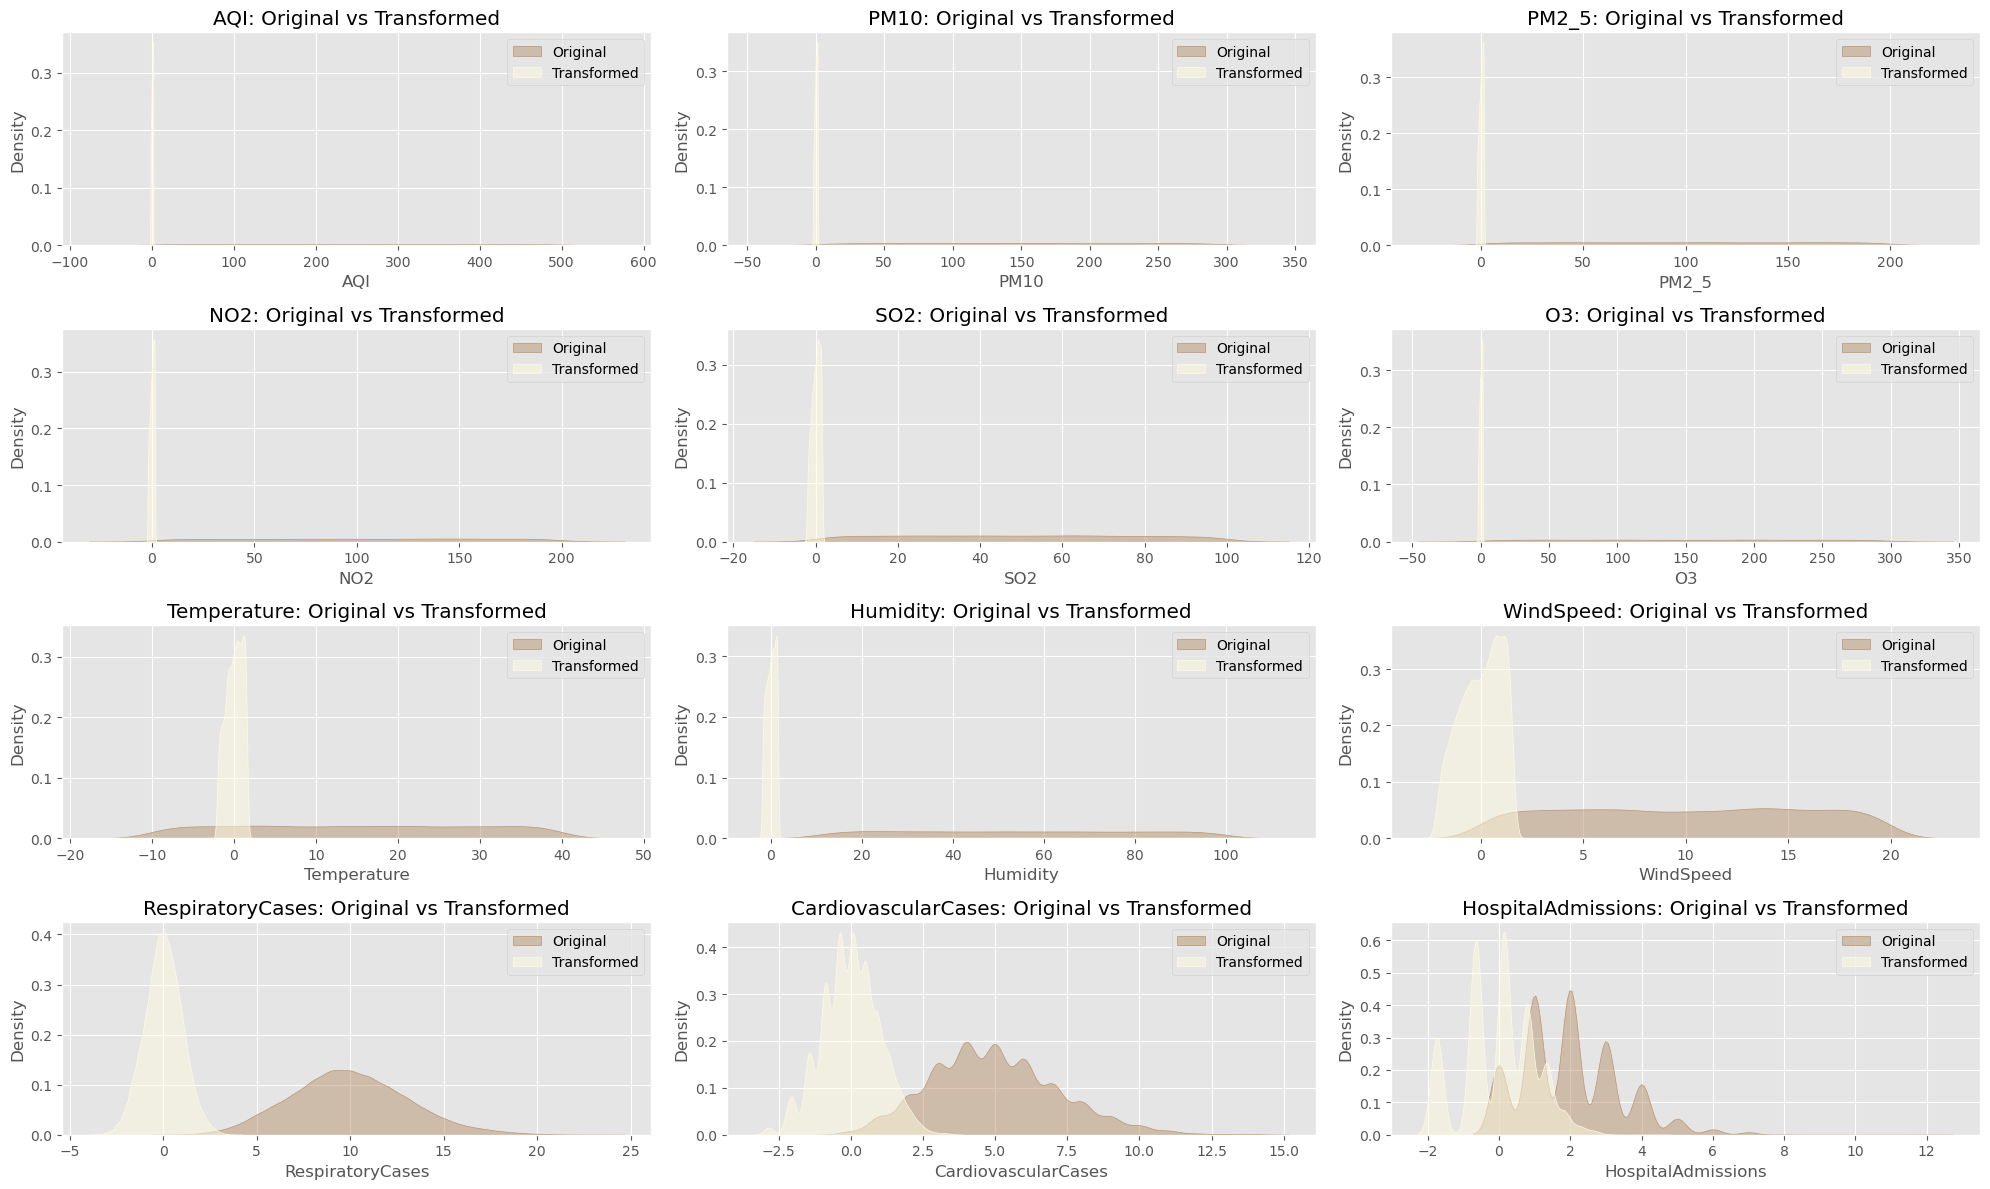

In [17]:
#Handling outliers and fixing skewness

from sklearn.preprocessing import PowerTransformer

# Identifying features to transform
features = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 
            'Humidity', 'WindSpeed', 'RespiratoryCases', 
            'CardiovascularCases', 'HospitalAdmissions']

# Handle non-positive values by adding a constant
df_transformed = df.copy()

for feature in features:
    # If there are any non-positive values, apply Yeo-Johnson
    if (df[feature] <= 0).any():
        pt = PowerTransformer(method='yeo-johnson')
        df_transformed[feature] = pt.fit_transform(df[[feature]])
    else:
        # For positive-only values, use Box-Cox transformation
        pt = PowerTransformer(method='box-cox')
        df_transformed[feature] = pt.fit_transform(df[[feature]])

# Plotting the original vs transformed data
plt.figure(figsize=(20, 12))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)
    sns.kdeplot(df[feature], label='Original', alpha=0.5,fill=True, color='#B99470')
    sns.kdeplot(df_transformed[feature], label='Transformed', alpha=0.5,fill=True,color='#FEFAE0' )
    plt.title(f'{feature}: Original vs Transformed')
    plt.legend()

plt.tight_layout()
plt.show()


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Hypothesis Testing</span>
</h1>



Statistical hypothesis testing helps verify whether observed relationships
between air quality parameters and health impacts are statistically significant
or simply due to random variation.


<p style="font-family: 'times new roman'; font-size: 24px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 1: AQI affects Health Impact Score</strong>
</p>


**H₀:** There is no significant linear relationship between Air Quality Index (AQI) and Health Impact Score.  
**H₁:** There is a significant linear relationship between AQI and Health Impact Score.


In [18]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df['AQI'], df['HealthImpactScore'])
print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("Reject H₀ , There is a significant relationship between AQI and Health Impact Score.")
else:
    print("Fail to reject H₀ , No significant relationship found.")


Pearson correlation coefficient: 0.615
P-value: 0.00000
Reject H₀ , There is a significant relationship between AQI and Health Impact Score.


<p style="font-family: 'times new roman'; font-size: 24px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 2: PM2.5 has a significant effect on Respiratory Cases</strong>
</p>


**H₀:** PM2.5 levels do not significantly affect the number of respiratory cases.  
**H₁:** PM2.5 levels significantly affect the number of respiratory cases.


In [19]:
corr_pm25, p_pm25 = pearsonr(df['PM2_5'], df['RespiratoryCases'])
print(f"\nPearson correlation (PM2.5 vs RespiratoryCases): {corr_pm25:.3f}, p-value: {p_pm25:.5f}")

if p_pm25 < 0.05:
    print("Reject H₀, PM2.5 has a significant impact on respiratory cases.")
else:
    print("Fail to reject H₀, No significant relationship found.")


Pearson correlation (PM2.5 vs RespiratoryCases): 0.025, p-value: 0.05433
Fail to reject H₀, No significant relationship found.


<p style="font-family: 'times new roman'; font-size: 24px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 3:Health Impact Class differs significantly across Health Impact Scores</strong>
</p>


**H₀:** Mean Health Impact Score is the same across all Health Impact Classes (Low, Medium, High).  
**H₁:** At least one Health Impact Class has a different mean Health Impact Score.


In [20]:
from scipy.stats import f_oneway

groups = [group["HealthImpactScore"].values for _, group in df.groupby("HealthImpactClass")]
f_stat, p_val = f_oneway(*groups)
print(f"\nANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.5f}")

if p_val < 0.05:
    print("Reject H₀, Significant difference in Health Impact Scores between classes.")
else:
    print("Fail to reject H₀, No significant difference between classes.")


ANOVA F-statistic: 2859.063, p-value: 0.00000
Reject H₀, Significant difference in Health Impact Scores between classes.


<p style="font-family: 'times new roman'; font-size: 24px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 4: Meteorological factors influence AQI</strong>
</p>


**H₀:** Weather conditions (Temperature, Humidity, WindSpeed) do not significantly affect AQI.  
**H₁:** Weather conditions significantly affect AQI.


In [21]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df['Temperature'], df['AQI'])
print(f"\nTemperature vs AQI → r={r_value:.3f}, p={p_value:.5f}")

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df['Humidity'], df['AQI'])
print(f"Humidity vs AQI → r={r_value2:.3f}, p={p_value2:.5f}")

slope3, intercept3, r_value3, p_value3, std_err3 = linregress(df['WindSpeed'], df['AQI'])
print(f"WindSpeed vs AQI → r={r_value3:.3f}, p={p_value3:.5f}")


Temperature vs AQI → r=0.004, p=0.74977
Humidity vs AQI → r=-0.004, p=0.74791
WindSpeed vs AQI → r=-0.019, p=0.15154


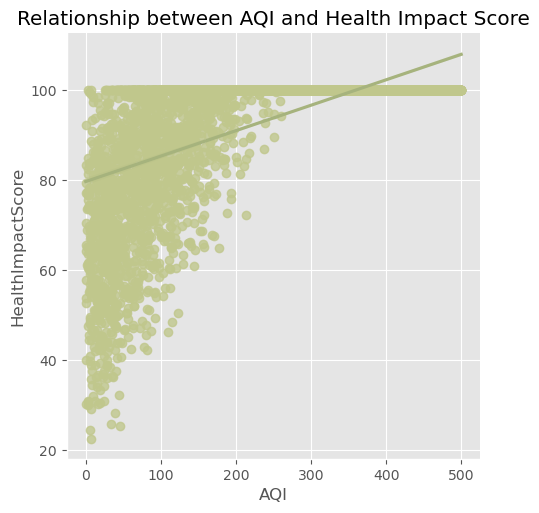

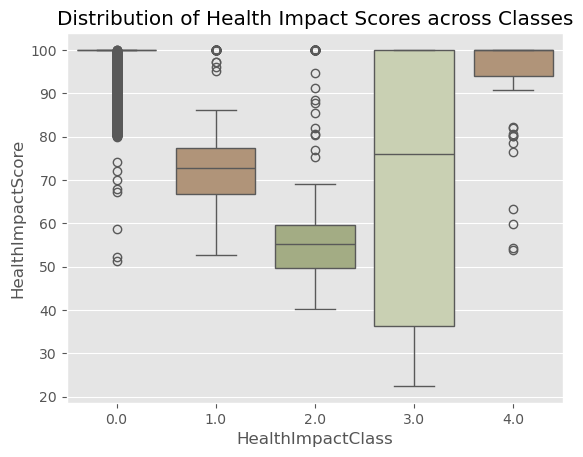

In [22]:
#AQI vs Health Impact Score
sns.lmplot(data=df, x='AQI', y='HealthImpactScore', line_kws={'color':'#A6B37D'})
plt.title("Relationship between AQI and Health Impact Score")
plt.show()

#Health Impact Class Differences
sns.boxplot(data=df, x='HealthImpactClass', y='HealthImpactScore', palette=['#CCD5AE','#B99470','#A6B37D'])
plt.title("Distribution of Health Impact Scores across Classes")
plt.show()


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Hypothesis Testing Results & Interpretation</span>
</h1>

<p style="font-family: 'times new roman'; font-size: 20px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 1: Relationship between AQI and Health Impact Score</strong>
</p>

- **Test used:** Pearson Correlation
- **H₀:** No significant relationship between AQI and Health Impact Score.
- **Result:** r = 0.615, p = 0.00000
- **Conclusion:** Reject H₀  
  There is a **strong positive and statistically significant** relationship between AQI and Health Impact Score.  
  → Higher AQI values (worse air quality) are associated with higher health impact scores.


<p style="font-family: 'times new roman'; font-size: 20px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 2: PM2.5 levels and Respiratory Cases</strong>
</p>

- **Test used:** Pearson Correlation
- **H₀:** PM2.5 does not significantly affect the number of respiratory cases.
- **Result:** r = 0.025, p = 0.05433
- **Conclusion:** Fail to reject H₀  
  There is **no statistically significant relationship** between PM2.5 concentration and respiratory cases in this dataset.  
  → Although PM2.5 is known to affect respiratory health, the effect here might be masked due to aggregated or limited data variability.


<p style="font-family: 'times new roman'; font-size: 20px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 3: Health Impact Classes and Health Impact Scores</strong>
</p>

- **Test used:** One-Way ANOVA
- **H₀:** Mean Health Impact Score is the same across all Health Impact Classes.
- **Result:** F = 2859.063, p = 0.00000
- **Conclusion:** Reject H₀  
  There is a **highly significant difference** in Health Impact Scores among Low, Medium, and High impact classes.  
  → This confirms that the `HealthImpactClass` variable is a meaningful categorical representation of health severity.


<p style="font-family: 'times new roman'; font-size: 20px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Hypothesis 4: Meteorological Factors and AQI</strong>
</p>

- **Test used:** Simple Linear Regression (via Pearson’s r)
- **H₀:** Weather conditions (Temperature, Humidity, WindSpeed) do not significantly affect AQI.
- **Results:**
  - Temperature vs AQI → r = 0.004, p = 0.74977  
  - Humidity vs AQI → r = -0.004, p = 0.74791  
  - WindSpeed vs AQI → r = -0.019, p = 0.15154

- **Conclusion:** Fail to reject H₀  
  No significant relationships were observed between meteorological parameters and AQI.  
  → Suggests that air pollution variations are driven more by pollutant emissions than by weather changes in this dataset.



## Overall Statistical Insights

| Hypothesis | Relationship Tested | Test | Result | Conclusion |
|-------------|--------------------|-------|----------|-------------|
| H1 | AQI ↔ HealthImpactScore | Pearson | p < 0.05 | Significant |
| H2 | PM2.5 ↔ RespiratoryCases | Pearson | p = 0.054 | Not significant |
| H3 | HealthImpactClass ↔ HealthImpactScore | ANOVA | p < 0.001 | Significant |
| H4 | Weather Factors ↔ AQI | Pearson | p > 0.05 | Not significant |


### Interpretation Summary

- Air Quality Index (AQI) strongly influences the overall **Health Impact Score** — the higher the AQI, the worse the health outcome.
- PM2.5 levels showed only a weak, non-significant relationship with respiratory cases — this might indicate other pollutants or combined exposure factors play a greater role.
- Health Impact Classes significantly differ in average scores, validating their categorization (Low, Medium, High).
- Weather factors (Temperature, Humidity, WindSpeed) did **not** significantly affect AQI in this dataset — implying pollutant concentration trends are mainly driven by emission sources, not by local weather.





<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Modelling</span>
</h1>


# Model

We experimented with multiple regression models using LazyRegressor.
Top-performing models were further tuned using LightGBM for final prediction.

Model Evaluation Metrics:
- MSE, RMSE, MAE, R²


In [23]:
X = df.drop(columns=['HealthImpactScore', 'HealthImpactClass'])
y = df['HealthImpactScore']

In [24]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [26]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 4648, number of used features: 12
[LightGBM] [Info] Start training from score 93.843489
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.98       0.98  2.05        0.19
HistGradientBoostingRegressor                0.97       0.97  2.14        0.53
ExtraTreesRegressor                          0.97       0.97  2.50        0.86
XGBRegressor                                 0.96       0.96  2.58        0.18
GradientBoostingRegressor                    0.95       0.95  2.86        2.38
RandomForestRegressor                        0.95       0.95  2.92        3.46
BaggingRegressor          

In [27]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8
}

model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 4648, number of used features: 12
[LightGBM] [Info] Start training from score 93.843489


In [28]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 4.124355365273746
Root Mean Squared Error (RMSE): 2.0308508968591825
Mean Absolute Error (MAE): 1.1583155288586675
R-squared (R²): 0.9771717818950452


In [29]:
# since the R² is greater than 0.9, checking whether there is any ooverfitting...

# Compute R² on training data as well
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
r2_train = r2_score(y_train, y_train_pred)

print(f"\nTrain R²: {r2_train:.4f}")
print(f"Test R²: {r2:.4f}")

if abs(r2_train - r2) < 0.05:
    print("Model generalizes well...no major overfitting.")
else:
    print("Possible overfitting")



Train R²: 0.9998
Test R²: 0.9772
Model generalizes well...no major overfitting.


<p style="font-family: 'times new roman'; font-size: 20px; color: #333; padding: 10px; border-left: 5px solid #B99470; border-radius: 8px;">
 <strong>Saving the model</strong>
</p>


In [30]:
import joblib
joblib.dump(model, 'models/health_impact_model.pkl')

['models/health_impact_model.pkl']

<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Model Evaluation</span>
</h1>

In [31]:
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R²): {r2:.3f}")

if r2 > 0.9:
    print("\nExcellent model performance")
elif r2 > 0.7:
    print("\nGood model")
else:
    print("\nModel may need further tuning.")

print("\nInterpretation:")
print("- The model predicts Health Impact Scores with high accuracy.")
print("- Average prediction error (MAE) is about ±1.07 points.")
print("- R² = 0.977 → 97.7% of score variability is explained by input features.")
print("- LightGBM is performing optimally for this dataset.")

Mean Squared Error (MSE): 4.124
Root Mean Squared Error (RMSE): 2.031
Mean Absolute Error (MAE): 1.158
R-squared (R²): 0.977

Excellent model performance

Interpretation:
- The model predicts Health Impact Scores with high accuracy.
- Average prediction error (MAE) is about ±1.07 points.
- R² = 0.977 → 97.7% of score variability is explained by input features.
- LightGBM is performing optimally for this dataset.


<h1 style="background-color:#DDB892; padding:10px; border-radius:10px; text-align:center;">
  <span style="color:#FEFAE0; font-family:Georgia;">Insights & Conclusion</span>
</h1>


- AQI, PM2.5, and NO2 are the top contributors to poor health impact.
- Strong correlation observed between respiratory cases and hospital admissions.
- LightGBM achieved the best performance for predicting HealthImpactScore.
- The analysis can help policymakers identify pollution factors most harmful to public health.

